In [6]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import *
from vqls import *
import time

label = 'sin'
lower = -1
upper = 1.
n_step = 20

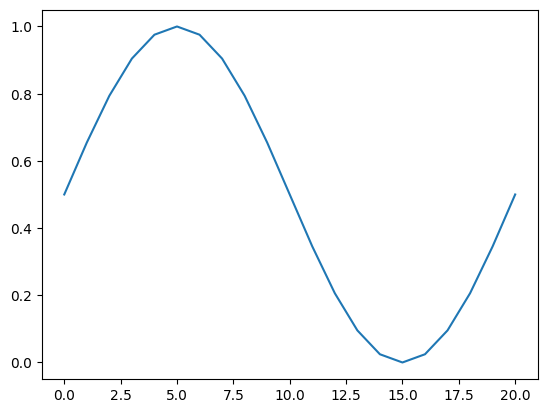

In [18]:
func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func = func_out[label]
func_dict = {'sigmoid': .0,'tanh': 1.0,'elu':.12, 'relu':.0, 'sin':-1}
f_i = func_dict[label]
x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]
plt.plot(y)

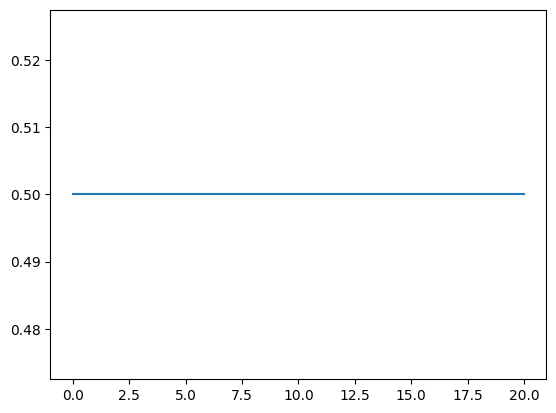